In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import scipy
import math
from scipy import stats
from collections import OrderedDict
import scipy.stats
import seaborn as sns
from IPython.display import Image
from pysal.viz.mapclassify import NaturalBreaks as nb
from pysal.viz.mapclassify import EqualInterval, UserDefined, FisherJenks, JenksCaspall

from matplotlib.collections import PatchCollection
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from collections import defaultdict

In [5]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Polygon

In [6]:
def figsize(scale,ratio):
    fig_width_pt = 500.484                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    if(ratio == "golden"):                          # Golden ratio ...
        fig_height = fig_width*golden_mean          # height in inches
    else:                                           # ... or other ratio
        fig_height = fig_width*ratio
        
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": False,                # use LaTeX to write all text
    "pgf.preamble": [
        r'\usepackage[light,math]{kurier}',
        r'\usepackage{amsmath}',
#        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
#        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

#plt.rcParams['axes.facecolor']='w'
plt.rcParams['axes.edgecolor']='k'
#plt.rcParams['text.color']='555555'

In [7]:
def fill_intervals(ax, steps, X, Y):
    last_step = None
    coordinates = []

    for i in range(1, len(steps)):
        if last_step == X.shape[0]:
            continue
        elif last_step is None:
            lower = np.argwhere(X >= steps[i-1])[0,0]
        else:
            lower = last_step
        
        if steps[i] == 1:
            upper = X.shape[0]-1
        elif i == len(steps)-1:
            upper = X.shape[0]-1
        else:
            upper = np.argwhere(X < steps[i])[-1, 0]
        
        if not upper:
            upper = X.shape[0]-1
            
        ax.fill_between(
            X[lower: upper+1],
            Y[lower: upper+1],
            color=color_cmap[i-1],
            alpha=1,
            linewidth=0, zorder=2
        )
        coordinates.append([steps[i-1], steps[i], Y[lower], Y[upper]])
        
        ax.plot([0, X[upper]], [Y[lower], Y[upper]], '--', color=np.array((200,200,200))/255, zorder=0)
        
        last_step = upper
        #print(X[lower], Y[lower])
        
    return ax, coordinates

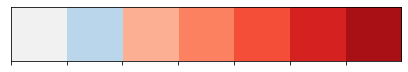

In [8]:
color_cmap = sns.color_palette("Reds", 6) #sns.cubehelix_palette(6, dark=0)#
color_cmap = np.hstack((color_cmap, np.ones((len(color_cmap), 1))))
background = np.hstack([np.array([241,241,241])/255., [1]])
#final = np.hstack([np.array([0,0,0])/255., [1]])
color_cmap = np.vstack((background, color_cmap))
#color_cmap = np.vstack((color_cmap, final))

# blue
color_cmap[1] = np.hstack([np.array([186,214,234])/255., [1]])

sns.palplot(color_cmap)

In [9]:
df = pd.read_csv('../data/generated_files/macro_05x05.csv')
df.loc[df['tile_km2'] < 0, 'tile_km2'] = 0

df['percent_urban'] = (df['urban_area_km2']/df['tile_km2'])*100
df.loc[df['percent_urban']<0, 'percent_urban'] = 0
df.loc[df['percent_urban']>100, 'percent_urban'] = 100
df = df.sort_values(['macro', 'percent_urban', 'tile_km2']).dropna()
df.head()

,macro,tileid,urban_area_km2,num_urban,tile_km2,percent_urban
171,Australia N. Zealand,69018,0.0,0,0.000457,0.0
165,Australia N. Zealand,68318,0.0,0,0.001996,0.0
240,Australia N. Zealand,72492,0.0,0,0.048548,0.0
2591,Australia N. Zealand,97291,0.0,0,0.052217,0.0
202,Australia N. Zealand,71086,0.0,0,0.158859,0.0


In [10]:
filtered_data = df.groupby('tileid').sum()['percent_urban'].values
#filtered_data = filtered_data[filtered_data > 0]

#steps = jenks(filtered_data, 7)
#steps

In [11]:
#steps = [0, 0.50, 0.80, 0.90, 0.95, 0.99, 1]
steps = [0, 0.01, 1.70, 4, 10, 30, 60, 100]

# Map

In [40]:
# Create some test data
df_summary = pd.read_csv('../data/generated_files/summary_tiles_05x05.csv')
df_summary.loc[df_summary['tile_km2']<0, 'tile_km2'] = 0

df_summary.loc[:, 'tile_km2_norm'] = df_summary['tile_km2']/df_summary['tile_km2'].sum()
df_summary['percent_urban'] = (df_summary['urban_area_km2']/df_summary['tile_km2'])*100
df_summary.loc[df_summary['percent_urban']<0, 'percent_urban'] = 0
df_summary.loc[df_summary['percent_urban']>100, 'percent_urban'] = 100
df_summary = df_summary.sort_values(['percent_urban', 'tile_km2'])
df_summary.head()

,tileid,urban_area_km2,urban_num,tile_km2,original_km2,tile_km2_norm,percent_urban
19190,147342,0.0,0,0.000001,2972.529465,9.394477e-15,0.0
36802,187888,0.0,0,0.000235,2237.358095,2.207702e-12,0.0
770,69018,0.0,0,0.000457,2362.722662,4.293276e-12,0.0
21860,155223,0.0,0,0.000700,2883.264965,6.576134e-12,0.0
62314,227534,0.0,0,0.001548,974.660087,1.454265e-11,0.0


In [41]:
df_summary['percent_urban'].mean()

1.7060261729371062

In [42]:
df_summary['urban_area_km2'].sum()/df_summary['tile_km2'].sum()

0.012233366372282811

In [43]:
df_summary.describe()

,tileid,urban_area_km2,urban_num,tile_km2,original_km2,tile_km2_norm,percent_urban
count,63507.000000,63507.000000,63507.000000,63507.000000,63507.000000,63507.000000,63457.000000
mean,168197.621790,20.504623,512.578172,1676.122712,2274.491780,0.000016,1.706026
std,44412.762313,69.402100,1482.637894,859.722221,665.916115,0.000008,5.687687
min,46585.000000,0.000000,0.000000,0.000000,818.730116,0.000000,0.000000
25%,135385.500000,0.000000,0.000000,1068.863794,1725.319046,0.000010,0.000000
50%,177864.000000,0.232187,14.000000,1650.626783,2429.395674,0.000016,0.016110
75%,205578.500000,9.124882,279.000000,2460.536073,2883.596567,0.000023,0.685946
max,231814.000000,1862.329759,32958.000000,3078.309389,3078.309389,0.000029,100.000000


/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """Entry point for launching an IPython kernel.
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

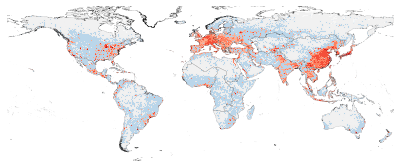

In [45]:
m = Basemap(projection='cyl', llcrnrlon=-180,llcrnrlat=-64,urcrnrlon=180.,urcrnrlat=80)

#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='#ddaa66',lake_color='aqua')
#map.drawcoastlines()

fig_size = figsize(1, "golden")
f, ax = plt.subplots(1,1, figsize=fig_size)#, figsize=(15,10))

#m.readshapefile('../ema/data/shps_world/ne_10m_land', 'comarques')
background = np.hstack([np.array([241,241,241])/255., [1]])

m.readshapefile('../data/m49/ne_10m_m49', 'borders', color=(0,0,0,0.), linewidth=0.0, drawbounds=True)

patches = []
for shape in m.borders:
    #x, y = zip(*shape) 
    #ax.plot(x, y, marker=None, color=(0,0,0,0.4))
    patches.append(Polygon(shape))    #'#C3C3C3'

ax.add_collection(PatchCollection(patches, zorder=3, facecolor=(0,0,0,0), edgecolor=(0,0,0,0.9), linewidth=0.1))


m.readshapefile('../data/generated_files/simple', 'tiles', color=(0,0,0,0), linewidth=0.1)
#ax.set_title(title)

data = []
data_for_sorting = []
shapes = []
for info, shape in zip(m.tiles_info, m.tiles):
    #data.append(info['tile_km2'])
    data.append(info['perc_urban']*100)
    shapes.append(shape)
    
#sorted_indexes = np.argsort(data_for_sorting)

data = np.array(data)#[sorted_indexes]
shapes = np.array(shapes)#[sorted_indexes]
data[data < 0] = 0
data[data > 100] = 100
indexes = np.argwhere(data)[:, 0]
#data = data[indexes]
#shapes = shapes[indexes]
filtered_data = np.cumsum(data/data.sum())#[indexes]

num_colors = len(color_cmap)
#breaks = Jenks_Caspall(data, k=num_colors)
#breaks = Percentiles(data, pct=[80, 90, 95, 100])
#breaks = User_Defined(filtered_data, jenks(filtered_data, num_colors)[1:])
breaks = UserDefined(data, steps[1:])
discrete_data = np.zeros(data.shape, dtype=np.uint8)

discrete_data = np.array(breaks.yb, dtype=np.uint8)+1
new_color_cmap = np.vstack([background, color_cmap])


c = mpl.colors.ListedColormap(new_color_cmap)
#norm = plt.Normalize(vmin=np.min(data), vmax=np.max(data))
#color = lambda x: c(norm(x))

ccccs = []
patches = defaultdict(list)
for perc_urban, orig_data, shape in zip(discrete_data, data, shapes):
    patches[int(perc_urban)].append(Polygon(shape))    #'#C3C3C3'

for k, v in patches.items():
    color = c(k)
    ax.add_collection(PatchCollection(v, zorder=2, facecolor=color, edgecolor=color, linewidth=0.008))
 
#sns.despine(left=True, bottom=True, ax=ax)
ax.axis('off')
plt.savefig('../figures/world-map.png', bbox_inches='tight', pad_inches=0.05, dpi=600)
plt.savefig('../figures/world-map.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

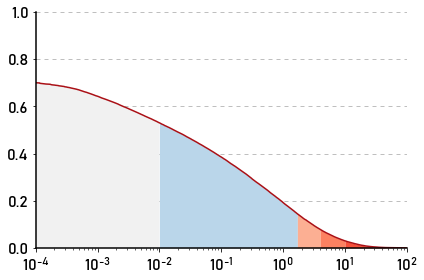

In [356]:
import matplotlib.image as mpimg

f, ax = plt.subplots(1,1)
ax.plot(X, Y, color=new_color_cmap[-1])
ax, _ = fill_intervals(ax, steps, X, Y)


ax.set_xscale('log')
ax.set_xlim(10**-4, 100) #
ax.set_ylim(0, 1.00)
     
for label in ax.get_yticklabels():
    label.set_fontproperties(prop)
    
for label in ax.get_xticklabels():
    label.set_fontproperties(prop2)
        
ax.tick_params(labelsize=16)
    
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

ax.grid(axis="y", zorder=3, linestyle='dashed', dashes=(5, 5))

plt.tight_layout()
sns.despine()
plt.savefig('global_ccdf.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

# Macro plots

In [46]:
def fill_intervals(ax, steps, X, Y):
    last_step = None
    coordinates = []

    for i in range(1, len(steps)):
        if last_step == X.shape[0]:
            continue
        elif last_step is None:
            lower = np.argwhere(X >= steps[i-1])[0,0]
        else:
            lower = last_step
        
        if steps[i] == 1:
            upper = X.shape[0]-1
        elif i == len(steps)-1:
            upper = X.shape[0]-1
        else:
            upper = np.argwhere(X < steps[i])[-1, 0]
        
        if not upper:
            upper = X.shape[0]-1
        
        
        if X[lower: upper+1][0] == 0:
            X[lower: upper+1][0] = -0.0001
        ax.fill_between(
            X[lower: upper+1],
            Y[lower: upper+1],
            color=color_cmap[i-1],
            alpha=1,
            linewidth=0, zorder=2
        )
        coordinates.append([steps[i-1], steps[i], Y[lower], Y[upper]])
        #ax.axhline(y=Y[upper], linestyle='--', color=np.array((200,200,200))/255, zorder=0)
        #ax.plot([0, X[upper]], [Y[upper], Y[upper]], '--', color=np.array((100,100,100))/255)
        
        last_step = upper
        #print(X[lower], Y[lower])
        
    return ax, coordinates

In [47]:
steps

[0, 0.01, 1.7, 4, 10, 30, 60, 100]

16 macroareas
Australia N. Zealand
 
Central America
 
Central Asia
 
Eastern Africa
 
Eastern Asia
 
Eastern Europe
 
Middle Africa
 
North America
 
Northern Africa
 
South America
 
Southeastern Asia
 
Southern Africa
 
Southern Asia
 
Western Africa
 
Western Asia
 
Western Europe
 


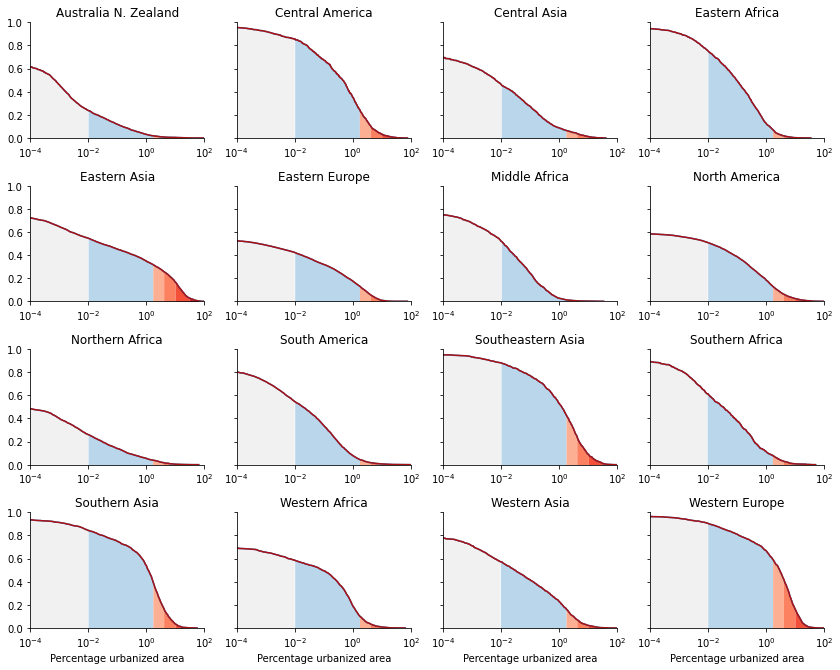

In [359]:
macros = df['macro'].drop_duplicates().values
n_macros = len(set(macros))

print(n_macros, "macroareas")

fig_size = figsize(1.7, 0.8)
f, axs = plt.subplots(4,4, figsize=fig_size, sharey=True)

i = 0
macro_coordinates = {}
for irow, row in enumerate(axs):
    for icol, ax in enumerate(row):
        macro = macros[i]
        print(macro)
        i += 1
        
        df_macro = df[df['macro'] == macro]
        X = df_macro['percent_urban'].values
        Y = df_macro['tile_km2'].values
        Y = 1-np.cumsum((Y/Y.sum()))
        
        ax.plot(X, Y)
        
        #Y = Y/Y[-1]

        ax.plot(X,Y, color=color_cmap[-1])
        #ax.set_xscale('symlog', linthresh=0.001)
        ax.set_xscale('log')
        ax.set_xlim(10**-4, 100) #
        ax.set_ylim(0,1)
        
        
        ax, macro_coordinates[macro] = fill_intervals(ax, steps, X, Y)
        
        #ax.set_title("Urbanized area per tile (0.5 degrees)")
        ax.set_title(macro)
        
        #if icol == 0:
        #    ax.set_ylabel("Probability covered area")
        if irow == 3:
            ax.set_xlabel("Percentage urbanized area")
        print(" ")
sns.despine()

plt.tight_layout()
#plt.savefig('figures/macro_cumulative.pdf', format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

In [360]:
coordinates_list = []
for k,v in macro_coordinates.items():
    for e in v:
        coordinates_list.append([k] + e)
coordinates_df = pd.DataFrame().from_records(coordinates_list, columns=['macro', 'lower_X', 'upper_X', 'lower_Y', 'upper_Y'])
coordinates_df.head()

,macro,lower_X,upper_X,lower_Y,upper_Y
0,Australia N. Zealand,0.00,0.01,1.000000,0.238475
1,Australia N. Zealand,0.01,1.70,0.238475,0.019267
2,Australia N. Zealand,1.70,4.00,0.019267,0.008406
3,Australia N. Zealand,4.00,10.00,0.008406,0.004957
4,Australia N. Zealand,10.00,30.00,0.004957,0.001146


In [361]:
import matplotlib.font_manager

path = 'Bahnschrift2.ttf'
prop2 = matplotlib.font_manager.FontProperties(fname=path)


path = '/Users/marcodena/Library/Fonts/bahnschrift_reg.ttf'
prop = matplotlib.font_manager.FontProperties(fname=path)

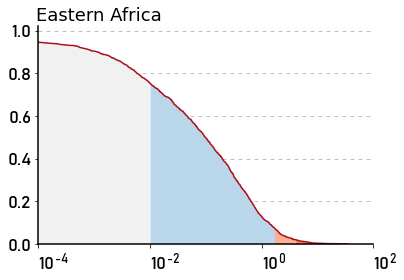

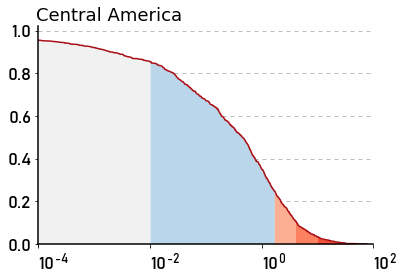

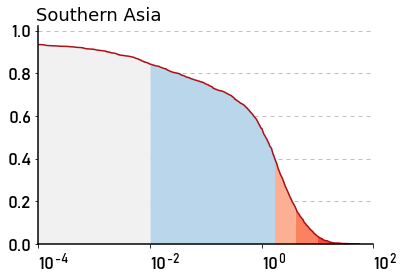

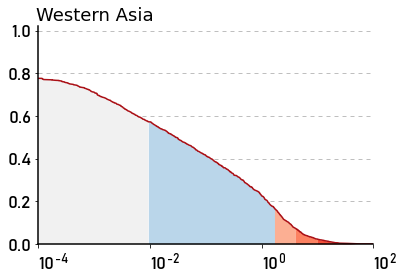

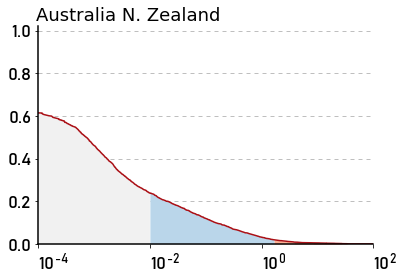

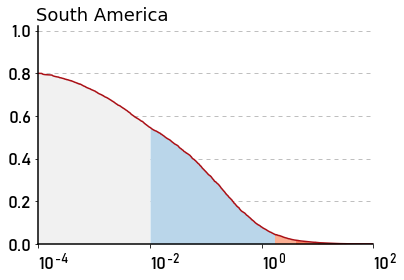

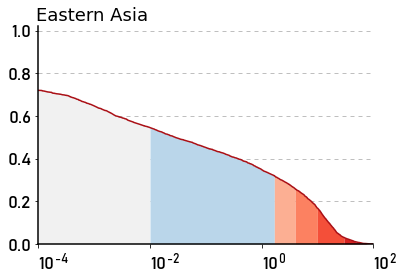

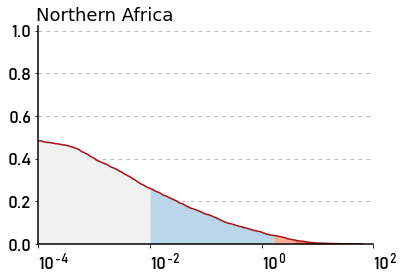

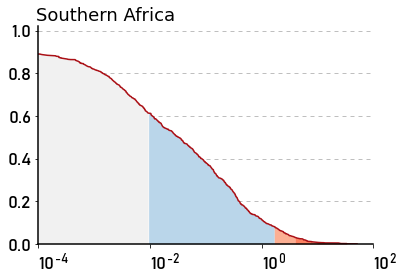

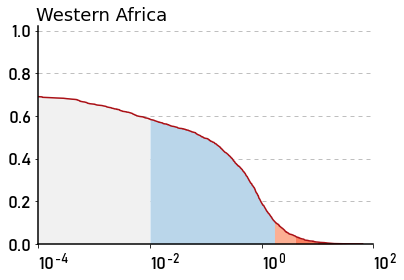

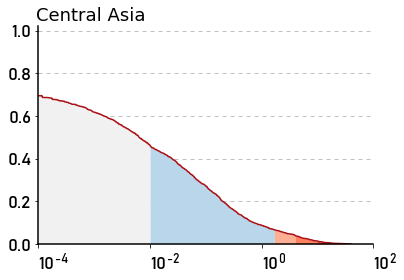

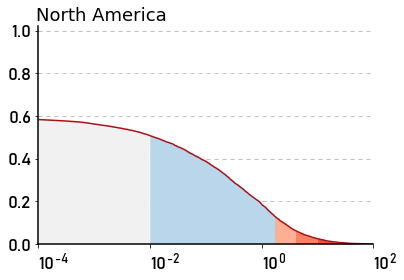

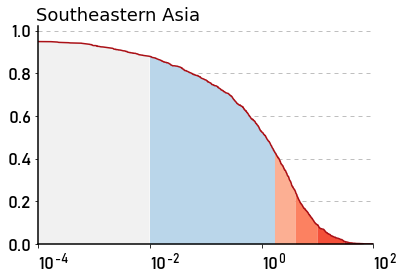

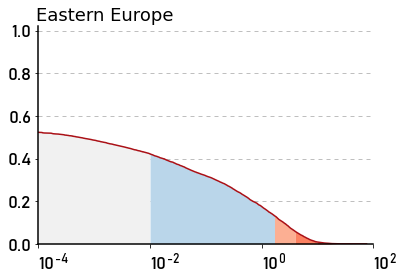

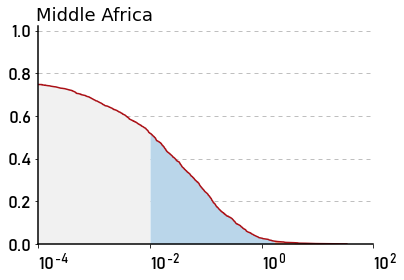

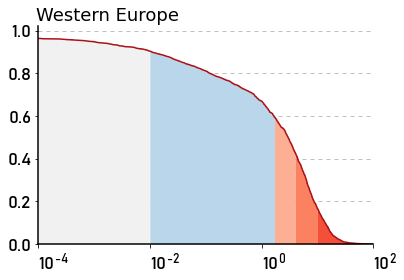

In [372]:

from matplotlib import ticker

def my_formatter_fun(x, p):
    """ Own formatting function """
    print(x)
    return r"$10$\textsuperscript{%i}" % x  #  raw string to avoid "\\"


macro_areas = set(coordinates_df['macro'].values)



for m in macro_areas:
    aa = df[df['macro'] == m]['tile_km2'].values

    X = df[df['macro'] == m]['percent_urban'].values
    Y = 1-np.cumsum(aa/aa.sum())

    f, ax = plt.subplots(1,1)

    ax.plot(X,Y, color=color_cmap[-1])
    ax.set_xscale('log')
    ax.set_xlim(10**-4, 100) #
    ax.set_ylim(0, 1.02)
    
    bbox = ax.get_yticklabels()[-1].get_window_extent()
    x,_ = ax.transAxes.inverted().transform([bbox.x0+5, bbox.y0])
    ax.set_title(m, fontsize=18, ha='left', x=x)
     
    for label in ax.get_yticklabels():
        label.set_fontproperties(prop)
    
    for label in ax.get_xticklabels():
        label.set_fontproperties(prop2)
    
    
    #ax.set_xticklabels(ax.get_xticklabels(), ha='right')
        
    ax.tick_params(labelsize=18)
    plt.setp(ax.get_xticklabels(), ha="left")
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    _ = fill_intervals(ax, steps, X, Y)
    ax.grid(axis="y", zorder=3, linestyle='dashed', dashes=(5, 5))
    f.set_facecolor("white")
    sns.despine()
    plt.savefig('../figures/manuscript/appendix_macro_{}.pdf'.format(m.replace(' ', '_')), format='pdf', transparent=True, bbox_inches='tight', pad_inches=0.05)

## Quantiles real

In [48]:
df_quantiles = pd.read_csv('../data/generated_files/quantiles_classes.csv', dtype={'tileid': str})
df_quantiles = df_quantiles.set_index('tileid')
df_quantiles['class'] = df_quantiles['class'].astype('int')
print(len(df_quantiles))
df_quantiles.head()

41917


,class,quantile
tileid,,
48003,3,0.861
48004,2,0.328
48005,3,0.602
48006,3,0.530
48007,3,0.760


In [49]:
urb_classes_colors = np.array([
    [237, 129, 69],
    [249, 227, 147],
    [226, 241, 199],
    [140, 169, 181],
])
urb_classes_colors  = urb_classes_colors/255.

/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


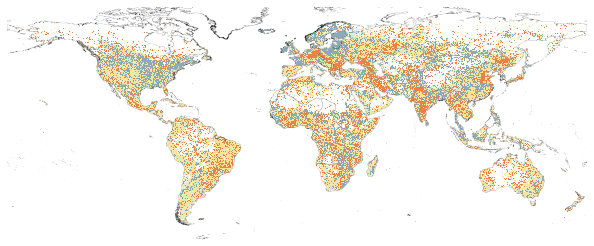

In [50]:
def create_tile_map(classname, ax):
    m = Basemap(projection='cyl', llcrnrlon=-180,llcrnrlat=-64,urcrnrlon=180.,urcrnrlat=80, ax=ax)
    m.readshapefile('../data/m49/ne_10m_m49', 'borders', color=(0,0,0,0.), linewidth=0.0, drawbounds=True)

    patches = []
    for shape in m.borders:
        patches.append(Polygon(shape))
    ax.add_collection(PatchCollection(patches, zorder=3, facecolor=(0,0,0,0), edgecolor=(0,0,0,0.9), linewidth=0.1))

    m.readshapefile('../data/generated_files/simple', 'tiles', color=(0,0,0,0), linewidth=0.1)
    shapes = defaultdict(list)
    for info, shape in zip(m.tiles_info, m.tiles):
        tile_id = str(info['tileid'])
        if tile_id in df_quantiles.index:
            urb_class = df_quantiles.loc[tile_id, classname]
            shapes[urb_class].append(Polygon(shape))

    for k, v in shapes.items():
        c = urb_classes_colors[k-1]
        ax.add_collection(PatchCollection(v, zorder=2, facecolor=c, edgecolor=c, linewidth=0.008))

fig_size = figsize(1.5, "golden")
f, ax = plt.subplots(1, 1, figsize=fig_size)#, figsize=(15,10))
background = np.hstack([np.array([241,241,241])/255., [1]])

## REAL WORLD
create_tile_map('class', ax)

ax.axis('off')

#f.savefig('../figures/manuscript/delete.pdf', bbox_inches='tight', pad_inches=0.05, dpi=300)
f.savefig('../figures/manuscript/figure3_map_raster.png', bbox_inches='tight', pad_inches=0.05, dpi=300)

## Quantiles world

In [51]:
df_quantiles = pd.read_csv('../data/generated_files/quantiles_classes_merged_all.csv', dtype={'tileid': str})
df_quantiles = df_quantiles.set_index('tileid')
df_quantiles['class_truth'] = df_quantiles['class_truth'].astype('int')
print(len(df_quantiles))
df_quantiles.head()

10306


,class_1000,quantile_1000,class_rybski,quantile_rybski,class_marco,quantile_marco,class_truth,quantile_truth
tileid,,,,,,,,
50123,1,0.035,1,0.048,1,0.037,1,0.038
52250,1,0.058,1,0.057,1,0.042,1,0.035
60513,1,0.033,1,0.095,1,0.050,1,0.048
60749,2,0.178,2,0.228,2,0.126,2,0.116
61225,1,0.002,1,0.002,1,0.002,1,0.006


In [52]:
urb_classes_colors = np.array([
    [237, 129, 69],
    [249, 227, 147],
    [226, 241, 199],
    [140, 169, 181],
])
urb_classes_colors  = urb_classes_colors/255.

/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marcodena/opt/miniconda3/envs/ema/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


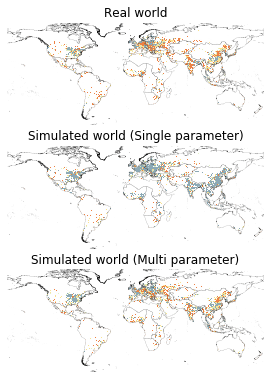

In [53]:
def create_tile_map(classname, ax):
    m = Basemap(projection='cyl', llcrnrlon=-180,llcrnrlat=-64,urcrnrlon=180.,urcrnrlat=80, ax=ax)
    m.readshapefile('../data/m49/ne_10m_m49', 'borders', color=(0,0,0,0.), linewidth=0.0, drawbounds=True)

    patches = []
    for shape in m.borders:
        patches.append(Polygon(shape))
    ax.add_collection(PatchCollection(patches, zorder=3, facecolor=(0,0,0,0), edgecolor=(0,0,0,0.9), linewidth=0.1))

    m.readshapefile('../data/generated_files/simple', 'tiles', color=(0,0,0,0), linewidth=0.1)
    shapes = defaultdict(list)
    for info, shape in zip(m.tiles_info, m.tiles):
        tile_id = str(info['tileid'])
        if tile_id in df_quantiles.index:
            urb_class = df_quantiles.loc[tile_id, classname]
            shapes[urb_class].append(Polygon(shape))

    for k, v in shapes.items():
        c = urb_classes_colors[k-1]
        ax.add_collection(PatchCollection(v, zorder=2, facecolor=c, edgecolor=c, linewidth=0.008))

fig_size = figsize(1.5, "golden")
f, axs = plt.subplots(3, 1, figsize=fig_size)#, figsize=(15,10))
background = np.hstack([np.array([241,241,241])/255., [1]])

## REAL WORLD
create_tile_map('class_truth', axs[0])

## SIMULATED WORLD RYBSKI
create_tile_map('class_rybski', axs[1])

## SIMULATED WORLD
create_tile_map('class_1000', axs[2])
    
axs[0].set_title("Real world")
axs[1].set_title("Simulated world (Single parameter)")
axs[2].set_title("Simulated world (Multi parameter)")
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

f.savefig('../figures/manuscript/simulated-world-map.png', bbox_inches='tight', pad_inches=0.05, dpi=300)